In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from colorama import Fore, Style
%matplotlib inline

In [2]:
# Введем функции подсчета точности доли правильных ответов
def accuracy_metric(actual, predicted):
    '''accuracy'''
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


def r2_metric(actual, predicted):
    '''R2 score'''
    return (1-np.sum((actual - predicted)**2) /
            np.sum((actual - np.mean(actual))**2))

In [3]:
def print_tree(node, spacing=''):
    '''печатает ход дерева'''

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(f'{Fore.GREEN}{spacing} ЛИСТ: прогноз = {str(node.prediction)}, \
объектов = {str(len(node.labels))}{Fore.BLACK}')
        return

    # Выведем значение индекса и порога на этом узле
    print(f'{Fore.RED}{spacing} УЗЕЛ: индекс = {str(node.index)}, \
порог = {str(round(node.t, 2))}, уровень = {str(node.level)}{Fore.BLACK}')

    # Рекурсионный вызов функции на true_branch
    print(f'{spacing} >>> Левая ветка:')
    print_tree(node.true_branch, f'{spacing}    ')

    # Рекурсионный вызов функции на false_branch
    print(f'{spacing} >>> Правая ветка:')
    print_tree(node.false_branch, f'{spacing}    ')

In [4]:
# Визуализируем дерево на графике
def visualize_a_tree_on_a_diagram(train_data, test_data,
                                  train_labels, test_labels):
    '''визуализирует дерево на графике +
    функции print_tree() и accuracy_metric()'''
    print_tree(my_tree)

    colors = ListedColormap(['red', 'blue', 'green'])
    light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightgreen'])

    def get_meshgrid(data, step=0.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return (np.meshgrid(np.arange(x_min, x_max, step),
                            np.arange(y_min, y_max, step)))

    plt.figure(figsize=(16, 7))

    # график обучающей выборки
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = (np.array(
        predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape))
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(train_data[:, 0],
                train_data[:, 1], c=train_labels, cmap=colors)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    plt.title(f'Train accuracy={train_accuracy:.2f}',
              fontweight='bold', fontsize=8)
    plt.xticks([])
    plt.yticks([])

    # график тестовой выборки
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    test_accuracy = accuracy_metric(test_labels, answers)
    plt.title(f'Test accuracy={test_accuracy:.2f}',
              fontweight='bold', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def counter_statistics():
    print(f'Узлов: {Node.count}\nЛистьев: {Leaf.count}')
    Node.count, Leaf.count, NodesCount.count, LeafsCount.count = 0, 0, 0, 0

## 1. В коде алгоритма построения дерева решений реализуйте один или несколько критериев останова: минимальное количество объектов в листе (min_leaf), максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции build_tree и проверьте ее работоспособность с помощью визуализации дерева.

критерии останова:
- ``min_leaf`` - минимальное количество объектов в листе принимается аргументом в функцию построения дерева **build_tree**, дефолтное значение критерия = 5
- добавил два класса - ``NodesCount`` и ``LeafsCount`` - они счётчики создаваемых объектов классов ``Node`` и ``Leaf``. По умолчанию ни на что не влияют, но при указании в функии построения дерева **build_tree** значений для аргументов ``count_nodes`` или ``count_leafs`` останавливают создание новых узлов или листов. Примеры с графиками и метриками ниже

In [6]:
# класс узла
class Node:
    count = 0

    def __init__(self, index, t, true_branch, false_branch, level):
        self.index = index                 # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t                         # значение порога
        self.true_branch = true_branch     # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch   # поддерево, не удовлетворяющее условию в узле
        self.level = level
        Node.count += 1

In [7]:
# класс листа (терминального узла)
class Leaf:
    count = 0

    def __init__(self, data, labels=None, targets=None):
        self.data = data
        self.labels = labels
        self.targets = targets
        self.prediction = self.predict()
        self.prediction_regr = self.predict_regr
        Leaf.count += 1

    def predict(self):
        '''возвращает класс, количество объектов которого максимально в конкретном'''
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        prediction = max(classes, key=classes.get)
        return prediction

    def predict_regr(self):
        return self.targets.mean()

In [8]:
# класс-счётчик для ограничения количества узлов
class NodesCount:
    count = 0

    def __init__(self, max_nodes):
        self.max_nodes = max_nodes
        NodesCount.count += 1

    def max_node(self):
        if self.max_nodes == 0:
            self.max_nodes = 1e15
        if NodesCount.count-1 >= self.max_nodes:
            return 'stop'


# класс-счётчик для ограничения количества листов
class LeafsCount:
    count = 0

    def __init__(self, max_leafs):
        self.max_leafs = max_leafs
        LeafsCount.count += 1

    def max_leaf(self):
        if self.max_leafs == 0:
            self.max_leafs = 1e15
        if LeafsCount.count >= self.max_leafs:
            return 'stop'

In [9]:
def gini(labels):
    '''индекс Джини'''
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    impurity = 1                 # коэффициент неопределенности Джини
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [10]:
def shannon_entropy(labels):
    '''энтропия Шеннона'''
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    entropy = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p != 0:
            entropy -= p * np.log2(p)

    return entropy

In [11]:
def mse(targets):
    '''MSE'''
    return np.mean((targets - targets.mean())**2)

In [12]:
def quality(left_labels, right_labels, criterion, choice_of_criterion):
    '''Расчет качества Q'''

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    if choice_of_criterion == 'shannon_entropy':
        return criterion - p * shannon_entropy(left_labels) - (1 - p) * shannon_entropy(right_labels)
    if choice_of_criterion == 'mse':
        return criterion - p * mse(left_labels) - (1 - p) * mse(right_labels)

    return criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [13]:
def split(data, labels, index, t):
    '''Разбиение датасета в узле'''

    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [14]:
def find_best_split(data, labels, min_leaf, criterion):
    '''Нахождение наилучшего разбиения'''

    current_gini = gini(labels)
    current_entropy = shannon_entropy(labels)
    current_mse = mse(labels)

    best_quality, best_t, best_index = 0, None, None
    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            if criterion == 'entropy':
                current_quality = quality(true_labels, false_labels, current_entropy, criterion)
            elif criterion == 'mse':
                current_quality = quality(true_labels, false_labels, current_mse, criterion)
            else:
                current_quality = quality(true_labels, false_labels, current_gini, criterion)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [15]:
def build_tree(data, labels, min_leaf=5, level=0, depth=0,
               count_nodes=0, count_leafs=0, criterion='gini', WHAT='cl'):
    '''Построение дерева'''

    if WHAT == 'regr':
        criterion = 'mse'

    quality, t, index = find_best_split(data, labels, min_leaf, criterion)

    #  прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        if WHAT == 'regr':
            return Leaf(data, targets=labels)
        else:
            return Leaf(data, labels=labels)
    # прекращаем рекурсию, когда достигнуто максимальное количество уровней
    if depth and level >= depth:
        if WHAT == 'regr':
            return Leaf(data, targets=labels)
        else:
            return Leaf(data, labels=labels)
    # прекращаем рекурсию, когда достигнуто максимальное количество узлов
    step_nodes = NodesCount(count_nodes)
    if step_nodes.max_node() == 'stop':
        if WHAT == 'regr':
            return Leaf(data, targets=labels)
        else:
            return Leaf(data, labels=labels)
    # прекращаем рекурсию, когда достигнуто максимальное количество листьев
    step_leafs = LeafsCount(count_leafs)
    if step_leafs.max_leaf() == 'stop':
        if WHAT == 'regr':
            return Leaf(data, targets=labels)
        else:
            return Leaf(data, labels=labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    level += 1

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_leaf,
                             level, depth, count_nodes, count_leafs)
    false_branch = build_tree(false_data, false_labels, min_leaf,
                              level, depth, count_nodes, count_leafs)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch, level)

In [16]:
def classify_object(obj, node, WHAT='cl'):
    '''определение класса'''

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        if WHAT == 'regr':
            answer = node.predict_regr
            return answer
        else:
            answer = node.prediction
            return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [17]:
def predict(data, tree):
    '''для предсказания'''

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

_____
_____

**сгенерируем данные и посмотрим на них**

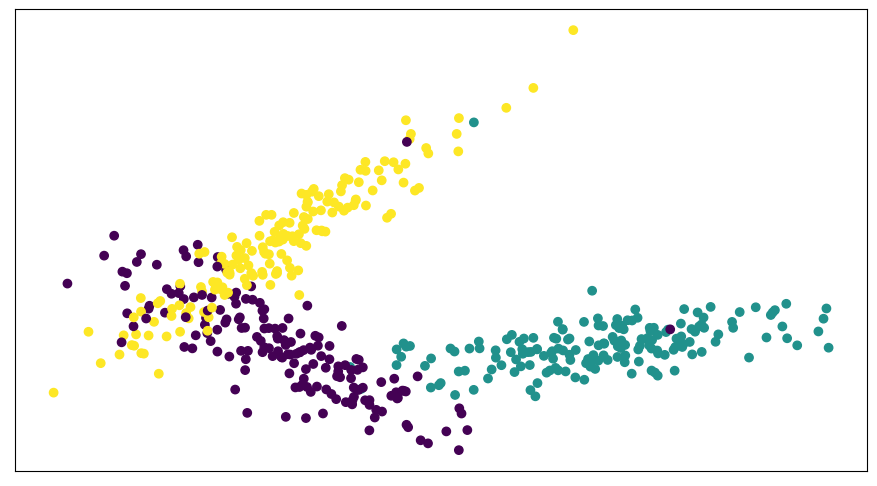

In [18]:
classification_data, classification_labels = datasets.make_classification(
                                                      n_samples=500,
                                                      n_features=2, n_informative=2, 
                                                      n_classes=3, n_redundant=0, 
                                                      n_clusters_per_class=1, 
                                                      random_state=5)

plt.figure(figsize=(11, 6))
plt.scatter(list(map(lambda x: x[0], classification_data)),
            list(map(lambda x: x[1], classification_data)), c=classification_labels)
plt.xticks([])
plt.yticks([])
plt.show()

Разобьем выборку 

In [19]:
train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

**1) Построим дерево по обучающей выборке без ограничений**

In [20]:
my_tree = build_tree(train_data, train_labels)

In [21]:
# Получим ответы для обучающей и тестовой выборки
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)

 УЗЕЛ: индекс = 0, порог = 0.15, уровень = 1
 >>> Левая ветка:
     УЗЕЛ: индекс = 1, порог = 0.12, уровень = 2
     >>> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -1.49, уровень = 3
         >>> Левая ветка:
             УЗЕЛ: индекс = 1, порог = -0.11, уровень = 4
             >>> Левая ветка:
                 УЗЕЛ: индекс = 1, порог = -0.35, уровень = 5
                 >>> Левая ветка:
                     УЗЕЛ: индекс = 1, порог = -0.71, уровень = 6
                     >>> Левая ветка:
                         ЛИСТ: прогноз = 2, объектов = 10
                     >>> Правая ветка:
                         ЛИСТ: прогноз = 0, объектов = 6
                 >>> Правая ветка:
                     ЛИСТ: прогноз = 2, объектов = 9
             >>> Правая ветка:
                 ЛИСТ: прогноз = 0, объектов = 5
         >>> Правая ветка:
             УЗЕЛ: индекс = 0, порог = -0.27, уровень = 4
             >>> Левая ветка:
                 УЗЕЛ: индекс = 0, порог = -1.44, уровень = 5

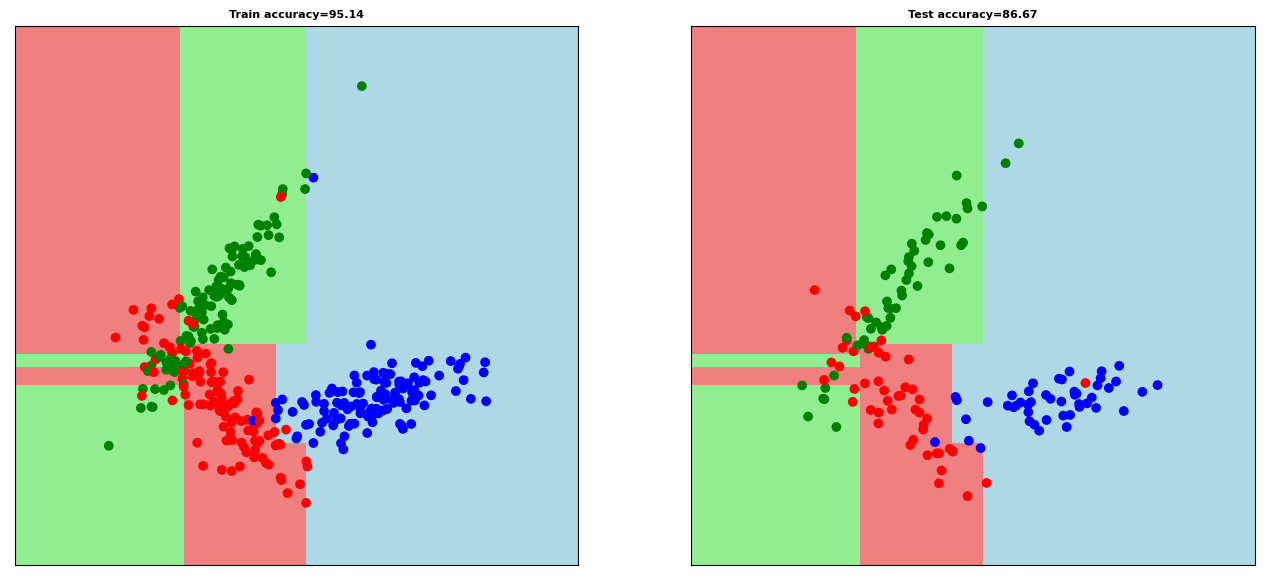

In [22]:
visualize_a_tree_on_a_diagram(train_data, test_data, train_labels, test_labels)

In [23]:
counter_statistics()

Узлов: 18
Листьев: 19


**2) Второе дерево ограничим по глубине дерева и количество наблюдений в листе увеличим, к примеру, до 7-ми**

 УЗЕЛ: индекс = 0, порог = 0.15, уровень = 1
 >>> Левая ветка:
     УЗЕЛ: индекс = 1, порог = 0.12, уровень = 2
     >>> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -1.49, уровень = 3
         >>> Левая ветка:
             УЗЕЛ: индекс = 1, порог = -0.23, уровень = 4
             >>> Левая ветка:
                 УЗЕЛ: индекс = 1, порог = -0.42, уровень = 5
                 >>> Левая ветка:
                     ЛИСТ: прогноз = 2, объектов = 14
                 >>> Правая ветка:
                     ЛИСТ: прогноз = 2, объектов = 7
             >>> Правая ветка:
                 ЛИСТ: прогноз = 0, объектов = 9
         >>> Правая ветка:
             УЗЕЛ: индекс = 0, порог = -0.27, уровень = 4
             >>> Левая ветка:
                 УЗЕЛ: индекс = 0, порог = -1.44, уровень = 5
                 >>> Левая ветка:
                     ЛИСТ: прогноз = 0, объектов = 9
                 >>> Правая ветка:
                     ЛИСТ: прогноз = 0, объектов = 81
             >>> Правая вет

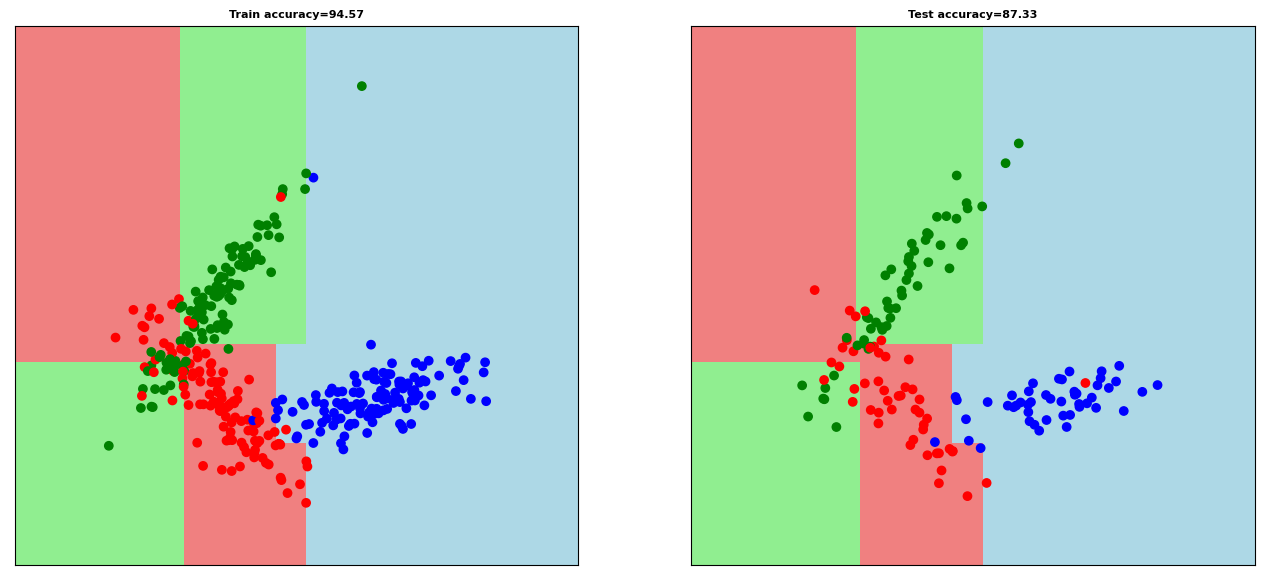

In [24]:
my_tree = build_tree(train_data, train_labels, min_leaf=7, depth=5)
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
visualize_a_tree_on_a_diagram(train_data, test_data, train_labels, test_labels)

In [25]:
counter_statistics()

Узлов: 12
Листьев: 13


**3) Третье дерево ограничим по количеству узлов**

 УЗЕЛ: индекс = 0, порог = 0.15, уровень = 1
 >>> Левая ветка:
     УЗЕЛ: индекс = 1, порог = 0.12, уровень = 2
     >>> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -1.49, уровень = 3
         >>> Левая ветка:
             УЗЕЛ: индекс = 1, порог = -0.11, уровень = 4
             >>> Левая ветка:
                 УЗЕЛ: индекс = 1, порог = -0.35, уровень = 5
                 >>> Левая ветка:
                     ЛИСТ: прогноз = 2, объектов = 16
                 >>> Правая ветка:
                     ЛИСТ: прогноз = 2, объектов = 9
             >>> Правая ветка:
                 ЛИСТ: прогноз = 0, объектов = 5
         >>> Правая ветка:
             ЛИСТ: прогноз = 0, объектов = 111
     >>> Правая ветка:
         ЛИСТ: прогноз = 2, объектов = 98
 >>> Правая ветка:
     ЛИСТ: прогноз = 1, объектов = 111


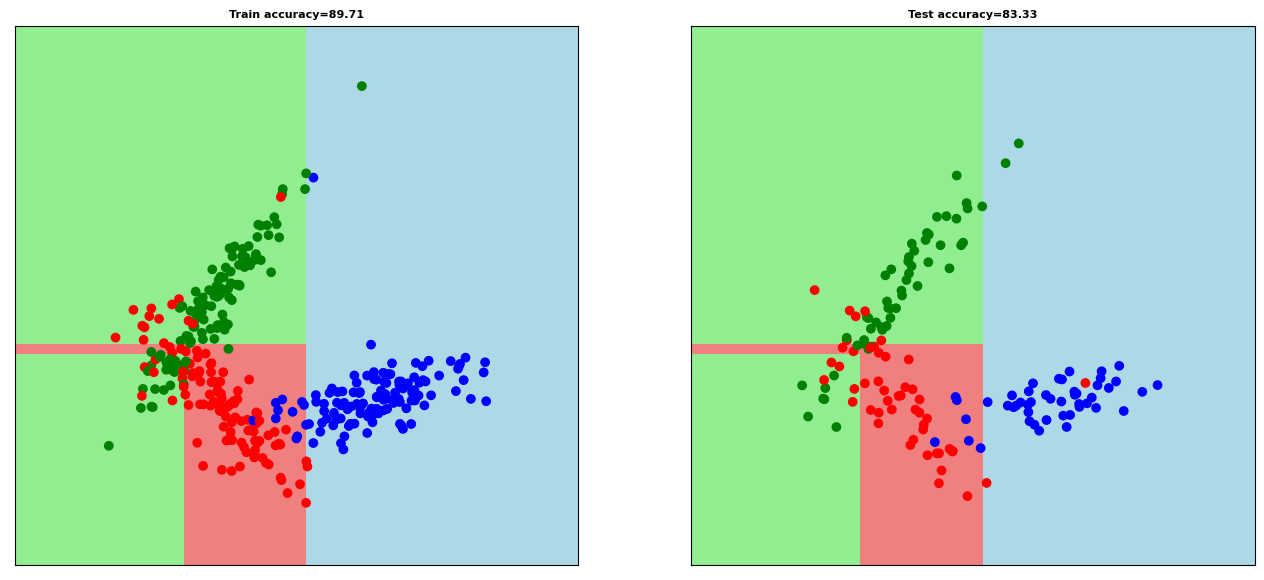

In [26]:
my_tree = build_tree(train_data, train_labels, count_nodes=5)
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
visualize_a_tree_on_a_diagram(train_data, test_data, train_labels, test_labels)

In [27]:
counter_statistics()

Узлов: 5
Листьев: 6


**4) Ну а четвёртому оставим всего 3 листика**

 УЗЕЛ: индекс = 0, порог = 0.15, уровень = 1
 >>> Левая ветка:
     УЗЕЛ: индекс = 1, порог = 0.12, уровень = 2
     >>> Левая ветка:
         ЛИСТ: прогноз = 0, объектов = 141
     >>> Правая ветка:
         ЛИСТ: прогноз = 2, объектов = 98
 >>> Правая ветка:
     ЛИСТ: прогноз = 1, объектов = 111


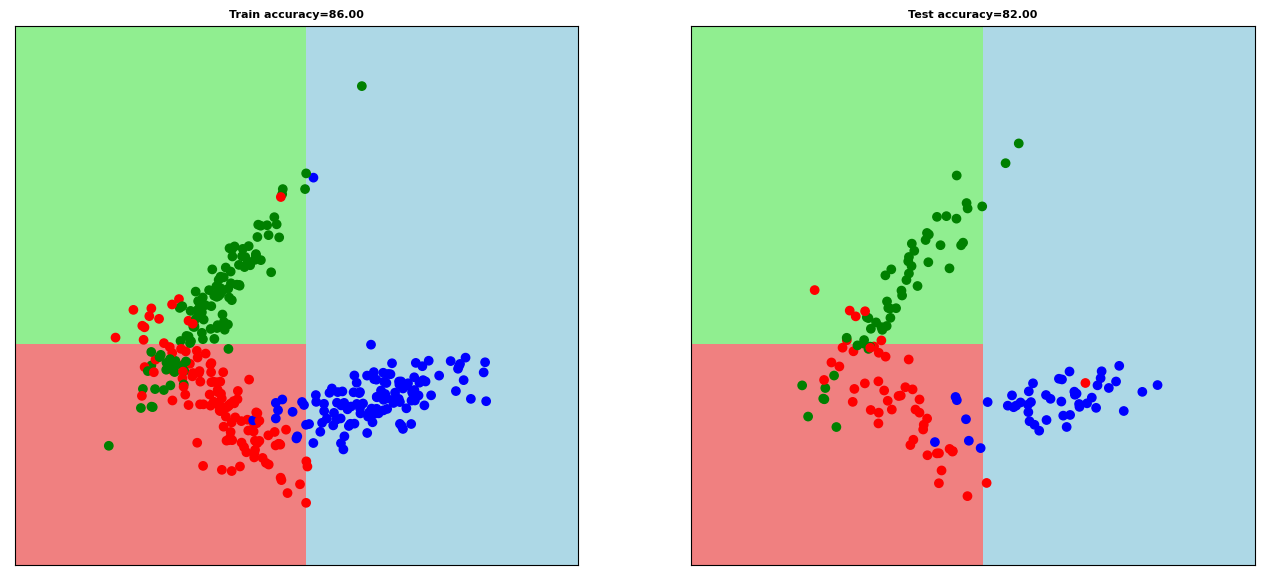

In [28]:
my_tree = build_tree(train_data, train_labels, count_leafs=3)
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
visualize_a_tree_on_a_diagram(train_data, test_data, train_labels, test_labels)

In [29]:
counter_statistics()

Узлов: 2
Листьев: 3


**Вывод:** все изменяемые параметры влияют на работу алгоритма, изменять их нужно с осторожностью 

## 2.  (*) Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия. Сравните качество классификации, сделайте выводы.

добавил функцию расчета Энтропии Шеннона. выбрать критерий просто - аргументом при вызове функции ```build_tree```

проверим на новой выборке

In [30]:
classification_data, classification_labels = datasets.make_classification(
                                                      n_samples=300,
                                                      n_features=2, n_informative=2,
                                                      n_classes=3, n_redundant=0,
                                                      n_clusters_per_class=1,
                                                      random_state=5)

train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.35,
                                                                    random_state=1)

**1) Индекс Джини**

In [31]:
my_tree = build_tree(train_data, train_labels, min_leaf=6, criterion='gini')
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
print(f'качество на трейне: {train_accuracy:.2f}\nкачество на тесте: {test_accuracy:.2f}')
counter_statistics()

качество на трейне: 94.36
качество на тесте: 88.57
Узлов: 11
Листьев: 12


**2) Энтропия Шеннона**

In [32]:
my_tree = build_tree(train_data, train_labels, min_leaf=6, criterion='entropy')
train_answers = predict(train_data, my_tree)
answers = predict(test_data, my_tree)
train_accuracy = accuracy_metric(train_labels, train_answers)
test_accuracy = accuracy_metric(test_labels, answers)
print(f'качество на трейне: {train_accuracy:.2f}\nкачество на тесте: {test_accuracy:.2f}')
counter_statistics()

качество на трейне: 94.36
качество на тесте: 88.57
Узлов: 11
Листьев: 12


**Вывод:** принципиальной разницы между критериями я не увидел

## 3. (*) Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений. Проверьте точность предсказания дерева на одной из метрик задачи регрессии.

код всё тот же, но в функцию построения дерева **build_tree()** добавлен аргумент ```WHAT```, который дефолтно = *'cl'* и строит дерево для задач классификации. Но если передать в ```WHAT``` значение *'regr'*, то дерево будет строиться для задач регрессии. 

Это видно при печати хода дерева функцией **print_tree()** - значения прогноза в листьях теперь вещественные числа

Проверим:

In [33]:
data, targets = datasets.make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.35, random_state=47)

In [35]:
my_tree = build_tree(X_train, y_train, WHAT='regr')

In [36]:
train_answers = predict(X_train, my_tree)
answers = predict(X_test, my_tree)

print_tree(my_tree)

 УЗЕЛ: индекс = 0, порог = -0.23, уровень = 1
 >>> Левая ветка:
     УЗЕЛ: индекс = 0, порог = -0.31, уровень = 2
     >>> Левая ветка:
         УЗЕЛ: индекс = 0, порог = -1.76, уровень = 3
         >>> Левая ветка:
             ЛИСТ: прогноз = -84.1885154282154, объектов = 5
         >>> Правая ветка:
             УЗЕЛ: индекс = 0, порог = -1.06, уровень = 4
             >>> Левая ветка:
                 ЛИСТ: прогноз = -34.918391906271395, объектов = 7
             >>> Правая ветка:
                 УЗЕЛ: индекс = 0, порог = -0.56, уровень = 5
                 >>> Левая ветка:
                     ЛИСТ: прогноз = -37.499144401574085, объектов = 8
                 >>> Правая ветка:
                     ЛИСТ: прогноз = -29.36593415743136, объектов = 9
     >>> Правая ветка:
         ЛИСТ: прогноз = 1.74763946357497, объектов = 5
 >>> Правая ветка:
     УЗЕЛ: индекс = 0, порог = 0.1, уровень = 2
     >>> Левая ветка:
         ЛИСТ: прогноз = 1.3781956032064766, объектов = 6
     >>> Пра

In [37]:
counter_statistics()

Узлов: 8
Листьев: 9


Посчитаем ```R2``` своей рукописной функцией согласно формуле:

$$R^2 = 1 - \frac{\sum_{i=1}^n(y_i - \hat{y_i})^2}{\sum_{i=1}^n(y_i - \bar{y_i})^2}$$

In [38]:
y_pred_train = predict(X_train, my_tree)
y_pred_test = predict(X_test, my_tree)

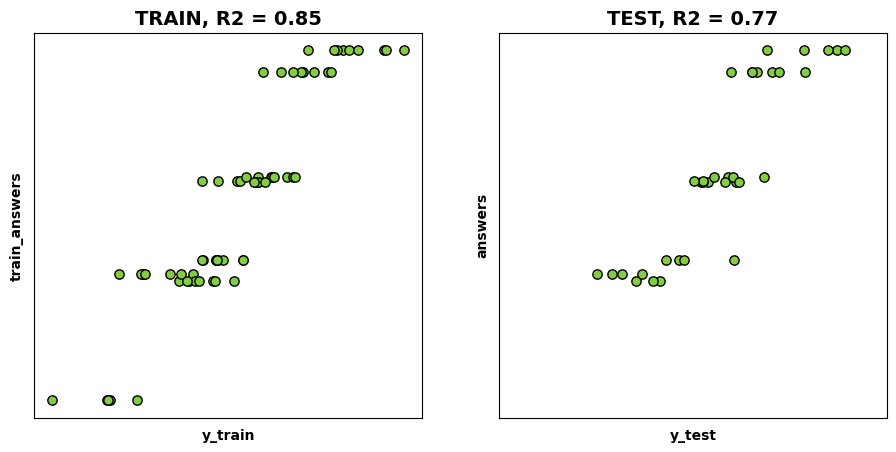

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 5), sharex=True, sharey=True)
ax1, ax2 = ax.flatten()
ax1.scatter(y_train, train_answers, c='#83CD42', edgecolor='black', s=45)
ax1.set_title(f'TRAIN, R2 = {r2_metric(y_train, y_pred_train):.2f}', fontweight='bold', fontsize=14)
ax1.set_xlabel('y_train', fontweight='bold')
ax1.set_ylabel('train_answers', fontweight='bold')
plt.xticks([])
plt.yticks([])
ax2.scatter(y_test, answers, c='#83CD42', edgecolor='black', s=45)
ax2.set_title(f'TEST, R2 = {r2_metric(y_test, y_pred_test):.2f}', fontweight='bold', fontsize=14)
ax2.set_xlabel('y_test', fontweight='bold')
ax2.set_ylabel('answers', fontweight='bold')
plt.xticks([])
plt.yticks([])
fig.set_size_inches(11, 5)
plt.show()